In [274]:
from __future__ import print_function
# key libs
import numpy as np
import re
import nltk
import pandas as pd
import glob
import codecs

# nlp libs
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer 

# processing
from sklearn.model_selection import train_test_split

# LDA
import pyLDAvis
import pyLDAvis.sklearn
pyLDAvis.enable_notebook()
from sklearn.decomposition import LatentDirichletAllocation
from scipy.sparse import csr_matrix
from sklearn.decomposition import NMF


# bring in my pickled vectorizers
import pickle
import dill


In [275]:
# what are we interestd in
# set this up to read the correct set of files we are interested in
topic_model = 'lda'
n_gram = '1gm' # options - 1gm , 2gm
stem_type = 'lemma' # options - lemma,snow

In [276]:
# set random state
RSEED = 0

### 1. OPEN - SENTIMENT ANALYSIS


In [277]:
sentiment_train=pd.read_csv('../data/sentiment_train.csv')
sentiment_test=pd.read_csv('../data/sentiment_test.csv')
sentiment_train = sentiment_train.drop(columns='Unnamed: 0')
sentiment_test = sentiment_test.drop(columns='Unnamed: 0')
sentiment_train.head()

,book_title,author_name,book_location,word_count,sentence_count,sentence_length,polarity,subjectivity
0,Behind the Beyond,Stephen Leacock,../data/gutenberg/Stephen Leacock___Behind the...,30101,2251,13.372279,0.093364,0.464357
1,Tommy and Co,Jerome Klapka Jerome,../data/gutenberg/Jerome Klapka Jerome___Tommy...,56198,4427,12.694375,0.099922,0.490483
2,Winsome Winnie and other New Nonsense Novels,Stephen Leacock,../data/gutenberg/Stephen Leacock___Winsome Wi...,39627,3042,13.026627,0.109288,0.477824
3,The Moccasin Ranch,Hamlin Garland,../data/gutenberg/Hamlin Garland___The Moccasi...,18347,1373,13.362709,0.069424,0.507020
4,Three Ghost Stories,Charles Dickens,../data/gutenberg/Charles Dickens___Three Ghos...,21181,1000,21.181000,0.071942,0.471564


In [278]:
sentiment_test.head()

,book_title,author_name,book_location,word_count,sentence_count,sentence_length,polarity,subjectivity
0,Great Catherine,George Bernard Shaw,../data/gutenberg/George Bernard Shaw___Great ...,14056,1779,7.901068,0.046192,0.528086
1,Short Cruises,William Wymark Jacobs,../data/gutenberg/William Wymark Jacobs___Shor...,50905,3621,14.058271,0.071414,0.487210
2,Richard Dare's Venture,Edward Stratemeyer,../data/gutenberg/Edward Stratemeyer___Richard...,46998,4007,11.728974,0.082732,0.475208
3,William Harvey And The Discovery Of The Circul...,Thomas Henry Huxley,../data/gutenberg/Thomas Henry Huxley___Willia...,8065,213,37.863850,0.148383,0.475731
4,Beyond,John Galsworthy,../data/gutenberg/John Galsworthy___Beyond.txt,118446,8497,13.939743,0.054021,0.492949


### 2. OPEN - TOPIC MODEL

In [279]:
# open pickled topic model pipeline
topic_pipe = dill.load(open('../data/vectors/'+ topic_model +'_'+ stem_type + '_' + n_gram,'rb'))

In [280]:
# load the train data
topic_train = pd.read_csv('../data/vectors/'+topic_model+'_'+ n_gram+'_'+ stem_type +'_train.csv')
topic_train = topic_train.drop(columns = 'Unnamed: 0')
topic_train.head()

,book_title,author_name,book_location,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,...,topic_11,topic_12,topic_13,topic_14,topic_15,topic_16,topic_17,topic_18,topic_19,topic_20
0,Behind the Beyond,Stephen Leacock,../data/gutenberg/Stephen Leacock___Behind the...,0.000006,0.000006,0.000006,0.056614,0.042713,0.000006,0.164503,...,0.066676,0.000006,0.000006,0.000006,0.000006,0.074134,0.000006,0.079391,0.000006,0.179807
1,Tommy and Co,Jerome Klapka Jerome,../data/gutenberg/Jerome Klapka Jerome___Tommy...,0.000003,0.021875,0.000003,0.000003,0.000003,0.000003,0.034393,...,0.004022,0.000003,0.000003,0.000003,0.004022,0.060004,0.172095,0.000003,0.000003,0.112089
2,Winsome Winnie and other New Nonsense Novels,Stephen Leacock,../data/gutenberg/Stephen Leacock___Winsome Wi...,0.000004,0.009116,0.076108,0.098339,0.008048,0.055905,0.199755,...,0.015974,0.008912,0.010840,0.040935,0.000004,0.105113,0.047032,0.000004,0.000004,0.131171
3,The Moccasin Ranch,Hamlin Garland,../data/gutenberg/Hamlin Garland___The Moccasi...,0.000009,0.000009,0.412892,0.166950,0.017638,0.000009,0.024758,...,0.000009,0.000145,0.051583,0.000009,0.000009,0.000009,0.000009,0.000009,0.000009,0.012090
4,Three Ghost Stories,Charles Dickens,../data/gutenberg/Charles Dickens___Three Ghos...,0.002563,0.082916,0.020869,0.071870,0.000009,0.000009,0.440103,...,0.000159,0.013008,0.017302,0.005694,0.070540,0.033966,0.009803,0.012162,0.007731,0.107179


In [281]:
# load the test data
topic_test = pd.read_csv('../data/vectors/'+topic_model+'_'+ n_gram+'_'+ stem_type +'_test.csv')
topic_test = topic_test.drop(columns = 'Unnamed: 0')
topic_test.head()

,book_title,author_name,book_location,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,...,topic_11,topic_12,topic_13,topic_14,topic_15,topic_16,topic_17,topic_18,topic_19,topic_20
0,Great Catherine,George Bernard Shaw,../data/gutenberg/George Bernard Shaw___Great ...,0.088418,0.000012,0.000012,0.000012,0.003382,0.000692,0.316283,...,0.000012,0.000012,0.000012,0.038180,0.000012,0.170649,0.129748,0.067013,0.000012,0.000012
1,Short Cruises,William Wymark Jacobs,../data/gutenberg/William Wymark Jacobs___Shor...,0.000003,0.000003,0.000003,0.013034,0.000003,0.000003,0.001170,...,0.000003,0.000003,0.006404,0.000572,0.000003,0.000003,0.048132,0.000003,0.000003,0.000003
2,Richard Dare's Venture,Edward Stratemeyer,../data/gutenberg/Edward Stratemeyer___Richard...,0.000004,0.000004,0.000004,0.000004,0.000004,0.156210,0.016494,...,0.046273,0.000004,0.000004,0.000004,0.000004,0.000004,0.070800,0.000004,0.000004,0.000004
3,William Harvey And The Discovery Of The Circul...,Thomas Henry Huxley,../data/gutenberg/Thomas Henry Huxley___Willia...,0.000025,0.000025,0.000025,0.000025,0.000025,0.028644,0.000025,...,0.006689,0.048928,0.000025,0.000025,0.539049,0.350062,0.000025,0.000025,0.008489,0.000025
4,Beyond,John Galsworthy,../data/gutenberg/John Galsworthy___Beyond.txt,0.004891,0.000002,0.097843,0.056868,0.000896,0.000002,0.071941,...,0.000002,0.000002,0.000002,0.000002,0.000002,0.000002,0.007421,0.000002,0.002691,0.453285


### 3. JOIN ALL FEATURES
Join topic model features with sentiment analysis features.

In [282]:
print(topic_train.shape)
print(sentiment_train.shape)

(2428, 23)
(2428, 8)


In [283]:
feature_train = pd.merge(topic_train,sentiment_train, on='book_location', how='inner')
feature_test = pd.merge(topic_test,sentiment_test, on='book_location', how='inner')

In [284]:
# train
feature_train = feature_train.drop(columns =['book_title_y','author_name_y'])
feature_train.rename(columns={'book_title_x': 'book_title'}, inplace=True)
feature_train.rename(columns={'author_name_x': 'author_name'}, inplace=True)

# test
feature_test = feature_test.drop(columns =['book_title_y','author_name_y'])
feature_test.rename(columns={'book_title_x': 'book_title'}, inplace=True)
feature_test.rename(columns={'author_name_x': 'author_name'}, inplace=True)

Note : why minmaxscaler ->  because the topics are percentages and range from 0 to 1 not -1 to +1 

In [285]:
# normalize certain columns
from sklearn import preprocessing
min_max_scaler = preprocessing.MinMaxScaler()

# log transform the counts 
column_names_to_log_1 = ['word_count', 'sentence_count', 'sentence_length']

feature_train.loc[:,column_names_to_log_1] = feature_train.loc[:,column_names_to_log_1].apply(np.log)
feature_test.loc[:,column_names_to_log_1] = feature_test.loc[:,column_names_to_log_1].apply(np.log)

# normalize subjectivity and polarity
column_names_to_normalize = ['subjectivity', 'polarity']

# train
x = feature_train[column_names_to_normalize].values
x_scaled = min_max_scaler.fit_transform(x)
df_temp = pd.DataFrame(x_scaled, columns=column_names_to_normalize, index = feature_train.index)
feature_train[column_names_to_normalize] = df_temp

# test
y = feature_test[column_names_to_normalize].values
y_scaled = min_max_scaler.transform(y)
df_temp = pd.DataFrame(y_scaled, columns=column_names_to_normalize, index = feature_test.index)
feature_test[column_names_to_normalize] = df_temp

In [286]:
feature_train.head()

,book_title,author_name,book_location,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,...,topic_16,topic_17,topic_18,topic_19,topic_20,word_count,sentence_count,sentence_length,polarity,subjectivity
0,Behind the Beyond,Stephen Leacock,../data/gutenberg/Stephen Leacock___Behind the...,0.000006,0.000006,0.000006,0.056614,0.042713,0.000006,0.164503,...,0.074134,0.000006,0.079391,0.000006,0.179807,10.312314,7.719130,2.593184,0.463344,0.438980
1,Tommy and Co,Jerome Klapka Jerome,../data/gutenberg/Jerome Klapka Jerome___Tommy...,0.000003,0.021875,0.000003,0.000003,0.000003,0.000003,0.034393,...,0.060004,0.172095,0.000003,0.000003,0.112089,10.936636,8.395477,2.541159,0.481264,0.534175
2,Winsome Winnie and other New Nonsense Novels,Stephen Leacock,../data/gutenberg/Stephen Leacock___Winsome Wi...,0.000004,0.009116,0.076108,0.098339,0.008048,0.055905,0.199755,...,0.105113,0.047032,0.000004,0.000004,0.131171,10.587266,8.020270,2.566996,0.506857,0.488050
3,The Moccasin Ranch,Hamlin Garland,../data/gutenberg/Hamlin Garland___The Moccasi...,0.000009,0.000009,0.412892,0.166950,0.017638,0.000009,0.024758,...,0.000009,0.000009,0.000009,0.000009,0.012090,9.817221,7.224753,2.592468,0.397930,0.594432
4,Three Ghost Stories,Charles Dickens,../data/gutenberg/Charles Dickens___Three Ghos...,0.002563,0.082916,0.020869,0.071870,0.000009,0.000009,0.440103,...,0.033966,0.009803,0.012162,0.007731,0.107179,9.960860,6.907755,3.053105,0.404810,0.465239


In [287]:
#log transform all topics
feature_train.loc[:,'topic_1':'topic_20'] = feature_train.loc[:,'topic_1':'topic_20'].apply(np.log)
feature_test.loc[:,'topic_1':'topic_20'] = feature_test.loc[:,'topic_1':'topic_20'].apply(np.log)

In [288]:
feature_train.head()

,book_title,author_name,book_location,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,...,topic_16,topic_17,topic_18,topic_19,topic_20,word_count,sentence_count,sentence_length,polarity,subjectivity
0,Behind the Beyond,Stephen Leacock,../data/gutenberg/Stephen Leacock___Behind the...,-12.002609,-12.002609,-12.002609,-2.871504,-3.153252,-12.002609,-1.804827,...,-2.601882,-12.002609,-2.533365,-12.002609,-1.715871,10.312314,7.719130,2.593184,0.463344,0.438980
1,Tommy and Co,Jerome Klapka Jerome,../data/gutenberg/Jerome Klapka Jerome___Tommy...,-12.689609,-3.822413,-12.689609,-12.689609,-12.689609,-12.689609,-3.369898,...,-2.813341,-1.759709,-12.689609,-12.689609,-2.188462,10.936636,8.395477,2.541159,0.481264,0.534175
2,Winsome Winnie and other New Nonsense Novels,Stephen Leacock,../data/gutenberg/Stephen Leacock___Winsome Wi...,-12.318240,-4.697728,-2.575599,-2.319330,-4.822360,-2.884098,-1.610666,...,-2.252721,-3.056927,-12.318240,-12.318240,-2.031256,10.587266,8.020270,2.566996,0.506857,0.488050
3,The Moccasin Ranch,Hamlin Garland,../data/gutenberg/Hamlin Garland___The Moccasi...,-11.631952,-11.631952,-0.884569,-1.790058,-4.037696,-11.631952,-3.698611,...,-11.631952,-11.631952,-11.631952,-11.631952,-4.415382,9.817221,7.224753,2.592468,0.397930,0.594432
4,Three Ghost Stories,Charles Dickens,../data/gutenberg/Charles Dickens___Three Ghos...,-5.966696,-2.489925,-3.869492,-2.632903,-11.630886,-11.630886,-0.820747,...,-3.382406,-4.625073,-4.409436,-4.862522,-2.233253,9.960860,6.907755,3.053105,0.404810,0.465239


In [289]:
feature_test.head()

,book_title,author_name,book_location,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,...,topic_16,topic_17,topic_18,topic_19,topic_20,word_count,sentence_count,sentence_length,polarity,subjectivity
0,Great Catherine,George Bernard Shaw,../data/gutenberg/George Bernard Shaw___Great ...,-2.425681,-11.333081,-11.333081,-11.333081,-5.689161,-7.276132,-1.151119,...,-1.768147,-2.042163,-2.702868,-11.333081,-11.333081,9.550805,7.483807,2.066998,0.334446,0.671189
1,Short Cruises,William Wymark Jacobs,../data/gutenberg/William Wymark Jacobs___Shor...,-12.569326,-12.569326,-12.569326,-4.340226,-12.569326,-12.569326,-6.750774,...,-12.569326,-3.033802,-12.569326,-12.569326,-12.569326,10.837716,8.194506,2.643211,0.403368,0.522250
2,Richard Dare's Venture,Edward Stratemeyer,../data/gutenberg/Edward Stratemeyer___Richard...,-12.428336,-12.428336,-12.428336,-12.428336,-12.428336,-1.856556,-4.104774,...,-12.428336,-2.647894,-12.428336,-12.428336,-12.428336,10.757860,8.295798,2.462062,0.434294,0.478516
3,William Harvey And The Discovery Of The Circul...,Thomas Henry Huxley,../data/gutenberg/Thomas Henry Huxley___Willia...,-10.613000,-10.613000,-10.613000,-10.613000,-10.613000,-3.552829,-10.613000,...,-1.049645,-10.613000,-10.613000,-4.768995,-10.613000,8.995289,5.361292,3.633997,0.613686,0.480421
4,Beyond,John Galsworthy,../data/gutenberg/John Galsworthy___Beyond.txt,-5.320334,-13.308843,-2.324395,-2.867018,-7.018090,-13.308843,-2.631916,...,-13.308843,-4.903389,-13.308843,-5.917748,-0.791235,11.682212,9.047468,2.634744,0.355840,0.543159


In [290]:
# write to file
feature_train.to_csv('../data/final_train.csv')
feature_test.to_csv('../data/final_test.csv')

In [291]:
# # concat together for recommender
# feature_full = pd.concat([feature_train,feature_test],axis=0)
# feature_full.shape
# feature_full.to_csv('../data/final_full.csv')

In [292]:
dill.dump(min_max_scaler, open('../data/vectors/scaler','wb'))

### 4. CLUSTERING HARD

In [293]:
feature_train.describe()

,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9,topic_10,...,topic_16,topic_17,topic_18,topic_19,topic_20,word_count,sentence_count,sentence_length,polarity,subjectivity
count,2428.000000,2428.000000,2428.000000,2428.000000,2428.000000,2428.000000,2428.000000,2428.000000,2428.000000,2428.000000,...,2428.000000,2428.000000,2428.000000,2428.000000,2428.000000,2428.000000,2428.000000,2428.000000,2428.000000,2428.000000
mean,-8.223050,-8.476428,-7.961510,-6.993498,-8.125070,-8.829704,-7.463699,-9.191850,-7.808053,-7.782397,...,-7.996746,-7.508710,-8.686219,-7.931820,-7.416315,10.665799,7.677193,2.988606,0.467877,0.534923
std,4.677513,4.396123,4.600059,4.867171,4.704746,4.321150,4.716809,4.272847,4.977425,4.727458,...,4.694276,4.716585,4.436766,4.382939,4.887280,1.171656,1.214330,0.365530,0.094451,0.103872
min,-14.886347,-14.789663,-14.886347,-14.886347,-14.720918,-14.789663,-14.886347,-14.886347,-14.886347,-14.886347,...,-14.789663,-14.720918,-14.789663,-14.720918,-14.886347,5.634790,1.945910,1.703204,0.000000,0.000000
25%,-12.666199,-12.580288,-12.390433,-12.412863,-12.727304,-12.639655,-12.325565,-12.848058,-12.695587,-12.618712,...,-12.669099,-12.360694,-12.691380,-12.433666,-12.408380,10.010771,7.012114,2.761997,0.405117,0.476121
50%,-10.121417,-10.235665,-9.775086,-5.243321,-10.018600,-10.698276,-7.416454,-11.074415,-9.802005,-7.952502,...,-9.799792,-7.605923,-10.687831,-8.543620,-7.649211,10.966973,7.989729,2.993788,0.466642,0.540261
75%,-3.519025,-3.817137,-3.230973,-2.373180,-3.305743,-4.299169,-2.730199,-4.745302,-2.540151,-3.198242,...,-3.261168,-2.798187,-3.960975,-3.682253,-2.469552,11.500777,8.545245,3.218942,0.529624,0.596346
max,-0.013901,-0.260622,-0.082606,-0.257250,-0.238008,-0.055306,-0.304016,-0.002889,-0.000733,-0.000093,...,-0.170138,-0.003944,-0.408640,-0.000044,-0.107492,13.082641,10.327938,4.597774,1.000000,1.000000


In [294]:
X = feature_train.iloc[:,3:]

In [295]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
inertia = []
list_num_clusters = list(range(1,30))
for num_clusters in list_num_clusters:
    km = KMeans(n_clusters=num_clusters)
    km.fit(X)
    inertia.append(km.inertia_)

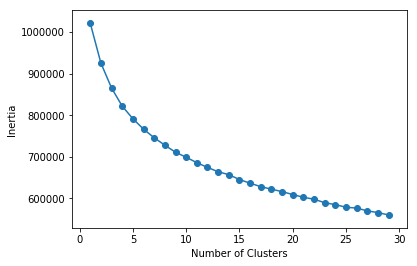

In [296]:
plt.plot(list_num_clusters,inertia)
plt.scatter(list_num_clusters,inertia)
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia');

try clusters at 10 or 15/16

In [297]:
# from sklearn.cluster import KMeans
# num_clusters = 10
# km = KMeans(n_clusters=num_clusters)
# km.fit(X)
# #display_cluster(X,km,num_clusters)

In [298]:
# clustered = km.transform(X)

In [299]:
# km.cluster_centers_

Component's weights: 
 [[-0.21 -0.22 -0.21 -0.18 -0.21 -0.22 -0.2  -0.23 -0.2  -0.2  -0.21 -0.22
  -0.22 -0.22 -0.21 -0.21 -0.19 -0.22 -0.2  -0.2   0.27  0.19  0.07  0.01
   0.01]
 [ 0.12  0.18 -0.25 -0.14  0.29  0.06 -0.1  -0.33 -0.45 -0.25  0.08  0.31
  -0.02 -0.09  0.21  0.25 -0.24  0.25  0.16 -0.17 -0.01 -0.04  0.02  0.
  -0.  ]]
Perc of Variance Explained: 
 [0.09 0.13]


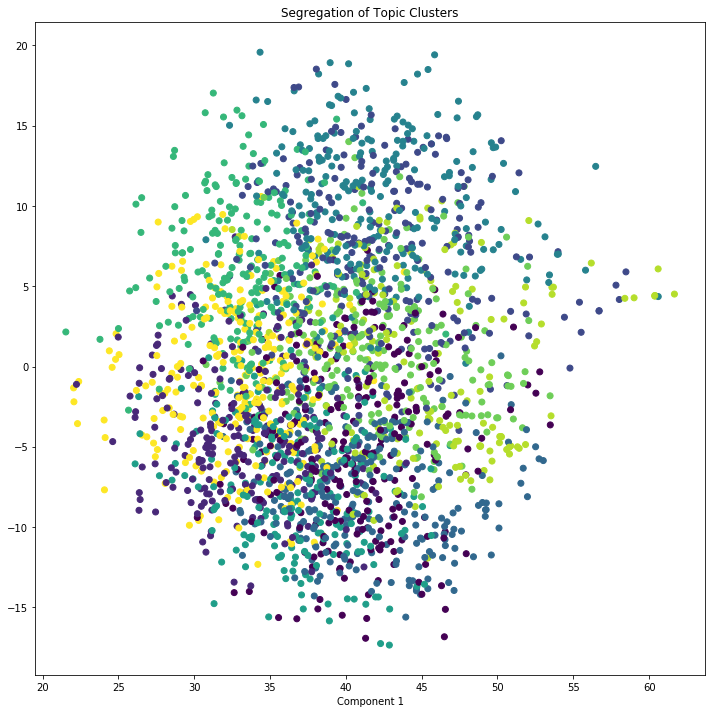

In [300]:
from sklearn.cluster import KMeans
from sklearn.decomposition import LatentDirichletAllocation, TruncatedSVD
clusters = KMeans(n_clusters=10, random_state=RSEED).fit_predict(X)

# Build the Singular Value Decomposition(SVD) model
svd_model = TruncatedSVD(n_components=2)  # 2 components
lda_output_svd = svd_model.fit_transform(X)

# X and Y axes of the plot using SVD decomposition
x = lda_output_svd[:, 0]
y = lda_output_svd[:, 1]

# Weights for the 15 columns of lda_output, for each component
print("Component's weights: \n", np.round(svd_model.components_, 2))

# Percentage of total information in 'lda_output' explained by the two components
print("Perc of Variance Explained: \n", np.round(svd_model.explained_variance_ratio_, 2))
plt.figure(figsize=(12, 12))
plt.scatter(x, y, c=clusters)
plt.xlabel('Component 2')
plt.xlabel('Component 1')
plt.title("Segregation of Topic Clusters", )
plt.savefig('../images/cluster.svg', format='svg',transparent=True )